In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score)

from xgboost import XGBClassifier, plot_importance, to_graphviz

from sklearn.metrics import (precision_recall_curve, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, auc)
from sklearn.metrics import (classification_report, confusion_matrix)

In [2]:
df = pd.read_csv('spy.csv', index_col=0, parse_dates=True)[['Adj Close']]

df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()

df

/var/folders/7q/6sr3f8p154zcxjkx38dw3tfc0000gn/T/ipykernel_29154/859417809.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('spy.csv', index_col=0, parse_dates=True)[['Adj Close']]


,Adj Close,Returns,Ret_1M
Date,,,
1927-12-30,17.660000,NaN,NaN
1928-01-03,17.760000,0.005647,NaN
1928-01-04,17.719999,-0.002255,NaN
1928-01-05,17.549999,-0.009640,NaN
1928-01-06,17.660000,0.006248,NaN
...,...,...,...
2024-01-12,4783.830078,0.000751,0.016172
2024-01-16,4765.979980,-0.003738,0.009790
2024-01-17,4739.209961,-0.005633,0.004233


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Close,24128.0,610.781503,978.568772,4.400000,24.570000,101.854999,996.034973,4839.810059
Returns,24127.0,0.000233,0.011986,-0.228997,-0.004575,0.000481,0.005449,0.153661
Ret_1M,24108.0,0.004649,0.053489,-0.548062,-0.019291,0.009629,0.033331,0.479470


In [4]:
df.isnull().sum()

Adj Close     0
Returns       1
Ret_1M       20
dtype: int64

In [5]:
features_list = []

for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

df.dropna(inplace=True)

df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60
Date,,,,,,,,,,,,,,,,,,,,,
1928-03-28,18.889999,-0.002644,0.090241,0.052157,0.006719,0.071871,0.006797,0.090241,0.006834,0.098969,...,0.077003,0.007094,0.068464,0.007259,0.088504,0.007050,0.076432,0.007337,0.067330,0.007352
1928-03-29,18.950001,0.003171,0.091098,0.047551,0.006682,0.071635,0.006801,0.091098,0.006823,0.100973,...,0.075611,0.007084,0.067675,0.007254,0.091098,0.007051,0.087059,0.007239,0.064855,0.007333
1928-03-30,19.280001,0.017264,0.108362,0.054355,0.007609,0.072593,0.006920,0.108362,0.007292,0.115322,...,0.095155,0.007453,0.095725,0.007378,0.110677,0.007354,0.105476,0.007530,0.084374,0.007610
1928-04-02,18.910000,-0.019377,0.073498,0.029516,0.010930,0.049319,0.009335,0.073498,0.008775,0.100028,...,0.070089,0.008186,0.070089,0.008014,0.084371,0.007928,0.079206,0.008025,0.074637,0.007946
1928-04-03,19.020000,0.005800,0.073623,0.029885,0.010939,0.059574,0.009100,0.073623,0.008776,0.102910,...,0.089021,0.007843,0.072491,0.008035,0.084434,0.007929,0.078729,0.008020,0.074189,0.007942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12,4783.830078,0.000751,0.016172,0.000100,0.006251,0.018030,0.005719,0.016172,0.006270,0.050259,...,0.062120,0.005415,0.088563,0.006271,0.131634,0.006570,0.118869,0.007152,0.089746,0.007541
2024-01-16,4765.979980,-0.003738,0.009790,-0.000808,0.006303,0.004043,0.005260,0.009790,0.006334,0.038584,...,0.056786,0.005479,0.083820,0.006327,0.117445,0.006531,0.129574,0.006830,0.099499,0.007314
2024-01-17,4739.209961,-0.005633,0.004233,-0.000764,0.006299,-0.003248,0.005456,0.004233,0.006480,0.028865,...,0.049964,0.005591,0.086304,0.006248,0.093129,0.006187,0.135844,0.006637,0.102385,0.007255


In [6]:
df.shape

(24068, 25)

In [7]:
df['Target'] = np.where(df['Adj Close'].shift(-1)>0.995 * df['Adj Close'], 1, 0)

df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
1928-03-28,18.889999,-0.002644,0.090241,0.052157,0.006719,0.071871,0.006797,0.090241,0.006834,0.098969,...,0.007094,0.068464,0.007259,0.088504,0.007050,0.076432,0.007337,0.067330,0.007352,1
1928-03-29,18.950001,0.003171,0.091098,0.047551,0.006682,0.071635,0.006801,0.091098,0.006823,0.100973,...,0.007084,0.067675,0.007254,0.091098,0.007051,0.087059,0.007239,0.064855,0.007333,1
1928-03-30,19.280001,0.017264,0.108362,0.054355,0.007609,0.072593,0.006920,0.108362,0.007292,0.115322,...,0.007453,0.095725,0.007378,0.110677,0.007354,0.105476,0.007530,0.084374,0.007610,0
1928-04-02,18.910000,-0.019377,0.073498,0.029516,0.010930,0.049319,0.009335,0.073498,0.008775,0.100028,...,0.008186,0.070089,0.008014,0.084371,0.007928,0.079206,0.008025,0.074637,0.007946,1
1928-04-03,19.020000,0.005800,0.073623,0.029885,0.010939,0.059574,0.009100,0.073623,0.008776,0.102910,...,0.007843,0.072491,0.008035,0.084434,0.007929,0.078729,0.008020,0.074189,0.007942,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12,4783.830078,0.000751,0.016172,0.000100,0.006251,0.018030,0.005719,0.016172,0.006270,0.050259,...,0.005415,0.088563,0.006271,0.131634,0.006570,0.118869,0.007152,0.089746,0.007541,1
2024-01-16,4765.979980,-0.003738,0.009790,-0.000808,0.006303,0.004043,0.005260,0.009790,0.006334,0.038584,...,0.005479,0.083820,0.006327,0.117445,0.006531,0.129574,0.006830,0.099499,0.007314,0
2024-01-17,4739.209961,-0.005633,0.004233,-0.000764,0.006299,-0.003248,0.005456,0.004233,0.006480,0.028865,...,0.005591,0.086304,0.006248,0.093129,0.006187,0.135844,0.006637,0.102385,0.007255,1


In [8]:
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'], axis=1)
X.values

array([[ 0.05215734,  0.00671895,  0.07187074, ...,  0.00733666,
         0.06733043,  0.00735201],
       [ 0.04755088,  0.00668158,  0.07163499, ...,  0.00723867,
         0.06485525,  0.00733311],
       [ 0.05435547,  0.00760921,  0.07259305, ...,  0.0075299 ,
         0.08437445,  0.00761034],
       ...,
       [-0.00076357,  0.00629918, -0.00324841, ...,  0.00663737,
         0.10238484,  0.0072553 ],
       [ 0.01605177,  0.00617777,  0.00129555, ...,  0.006614  ,
         0.12381671,  0.00706072],
       [ 0.03172435,  0.00672135,  0.01210442, ...,  0.00662186,
         0.13774201,  0.00716346]])

In [9]:
y = df['Target']
y

Date
1928-03-28    1
1928-03-29    1
1928-03-30    0
1928-04-02    1
1928-04-03    1
             ..
2024-01-12    1
2024-01-16    0
2024-01-17    1
2024-01-18    1
2024-01-19    0
Name: Target, Length: 24068, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Train and Test Size:", len(X_train), len(X_test))

Train and Test Size: 19254 4814


In [11]:
model = XGBClassifier(verbosity = 0, silent=True, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)

y_pred, y_proba

(array([1, 1, 1, ..., 1, 1, 1]),
 array([[0.21573126, 0.78426874],
        [0.08354896, 0.91645104],
        [0.16887969, 0.8311203 ],
        ...,
        [0.152681  , 0.847319  ],
        [0.06326199, 0.936738  ],
        [0.24446654, 0.75553346]], dtype=float32))

In [13]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print('Train Accuracy:', acc_train)
print('Test Accuracy:', acc_test)

Train Accuracy: 0.8721304663965929
Test Accuracy: 0.7528043207312006


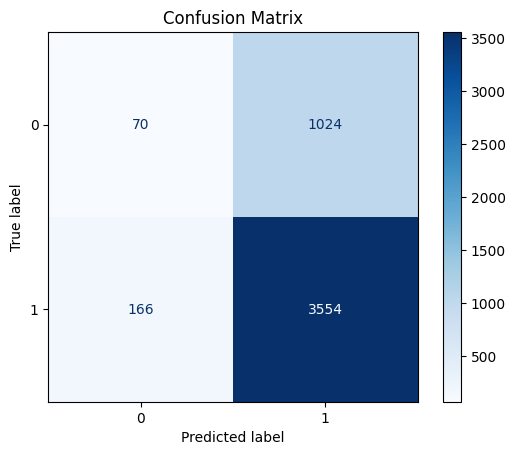

In [14]:
disp = ConfusionMatrixDisplay.from_estimator(model, 
                                             X_test,
                                             y_test,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues
                                            )
disp.ax_.set_title('Confusion Matrix')
plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.06      0.11      1094
           1       0.78      0.96      0.86      3720

    accuracy                           0.75      4814
   macro avg       0.54      0.51      0.48      4814
weighted avg       0.67      0.75      0.69      4814



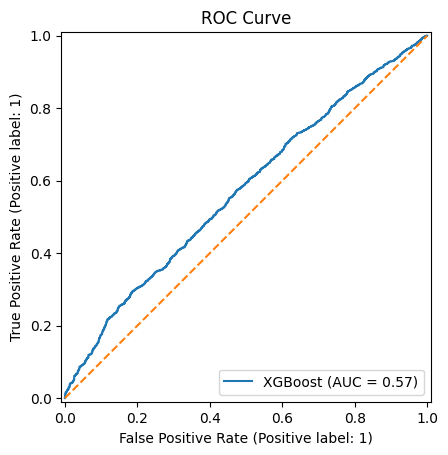

In [16]:
disp_roc = RocCurveDisplay.from_estimator(model, 
                                          X_test,
                                          y_test,
                                          name='XGBoost'
                                         )
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

In [17]:
tscv = TimeSeriesSplit(n_splits=4, gap=1)

for train, test in tscv.split(X):
    print(train, test)

[   0    1    2 ... 4812 4813 4814] [4816 4817 4818 ... 9626 9627 9628]
[   0    1    2 ... 9625 9626 9627] [ 9629  9630  9631 ... 14439 14440 14441]
[    0     1     2 ... 14438 14439 14440] [14442 14443 14444 ... 19252 19253 19254]
[    0     1     2 ... 19251 19252 19253] [19255 19256 19257 ... 24065 24066 24067]


In [18]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [19]:
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [20]:
param_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

In [21]:
rs = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='f1', cv=tscv, verbose=0)
rs.fit(X_train, y_train, verbose=0)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [22]:
rs.best_params_

{'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

In [23]:
rs.best_score_

0.8788844990471418

In [24]:
cls = rs.best_estimator_ # or cls = XGBClassifier(**rs.best_params_)

cls.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-logloss:0.54751	validation_1-logloss:0.53705
[1]	validation_0-logloss:0.54563	validation_1-logloss:0.53550
[2]	validation_0-logloss:0.54387	validation_1-logloss:0.53410
[3]	validation_0-logloss:0.54225	validation_1-logloss:0.53285
[4]	validation_0-logloss:0.54079	validation_1-logloss:0.53176
[5]	validation_0-logloss:0.53940	validation_1-logloss:0.53075
[6]	validation_0-logloss:0.53812	validation_1-logloss:0.52982
[7]	validation_0-logloss:0.53695	validation_1-logloss:0.52900
[8]	validation_0-logloss:0.53585	validation_1-logloss:0.52823
[9]	validation_0-logloss:0.53483	validation_1-logloss:0.52746
[10]	validation_0-logloss:0.53387	validation_1-logloss:0.52675
[11]	validation_0-logloss:0.53303	validation_1-logloss:0.52620
[12]	validation_0-logloss:0.53218	validation_1-logloss:0.52567
[13]	validation_0-logloss:0.53140	validation_1-logloss:0.52519
[14]	validation_0-logloss:0.53063	validation_1-logloss:0.52463
[15]	validation_0-logloss:0.52995	validation_1-logloss:0.52414
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
evals_result = cls.evals_result()
evals_result

{'validation_0': OrderedDict([('logloss',
               [0.5475093938562745,
                0.5456322535456087,
                0.5438729100872748,
                0.5422528391874033,
                0.5407853892727583,
                0.5394044089545784,
                0.538115381518882,
                0.5369468067134294,
                0.5358502766928334,
                0.5348330687101143,
                0.5338740501395326,
                0.533032728252882,
                0.5321846867358064,
                0.5313970530224735,
                0.5306283021567271,
                0.5299536663943317,
                0.529297478241633,
                0.5286680862781191,
                0.5280577719762614,
                0.5275329303797797,
                0.5270176200501654,
                0.5265307174733375,
                0.526058998649627,
                0.5256205363394725,
                0.5251976803124688,
                0.5248337890765149,
                0.52443545

In [26]:
score = cross_val_score(cls, X_train, y_train, cv=tscv)
print('Mean CV Score:', score.mean())

Mean CV Score: 0.7844811467746963


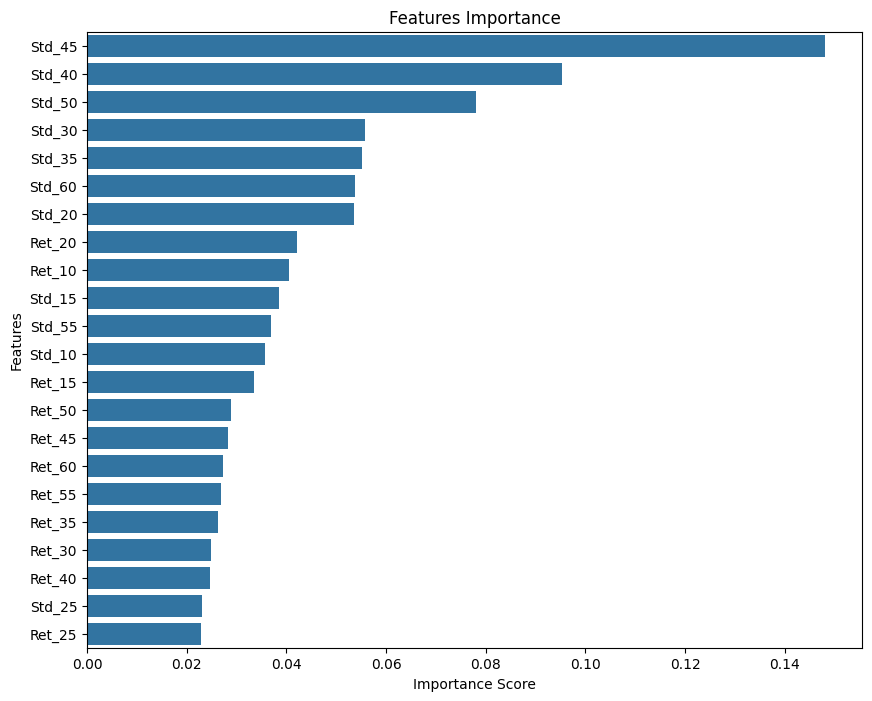

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,
                            'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

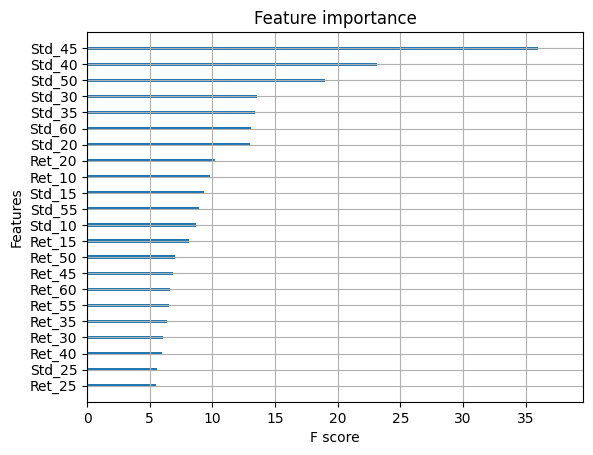

In [28]:
plot_importance(cls, importance_type='gain', show_values=False);

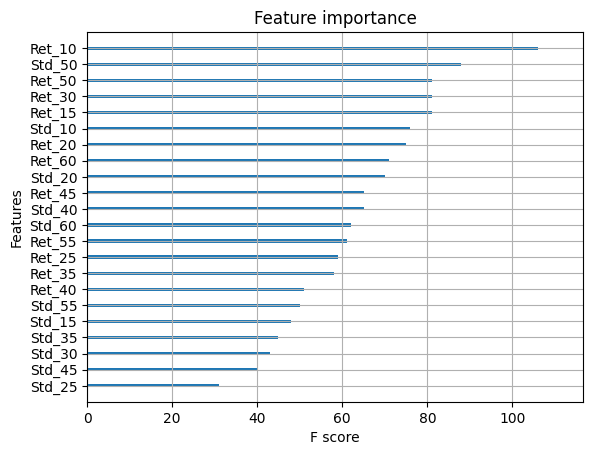

In [29]:
plot_importance(cls, importance_type='weight', show_values=False);

In [30]:
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

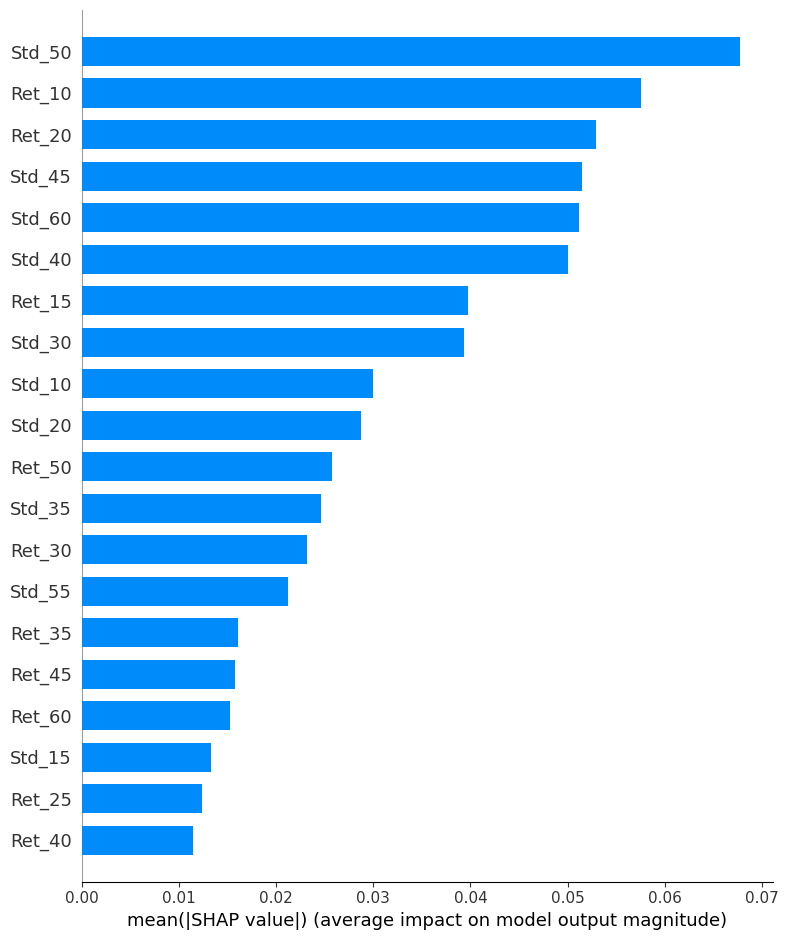

In [31]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

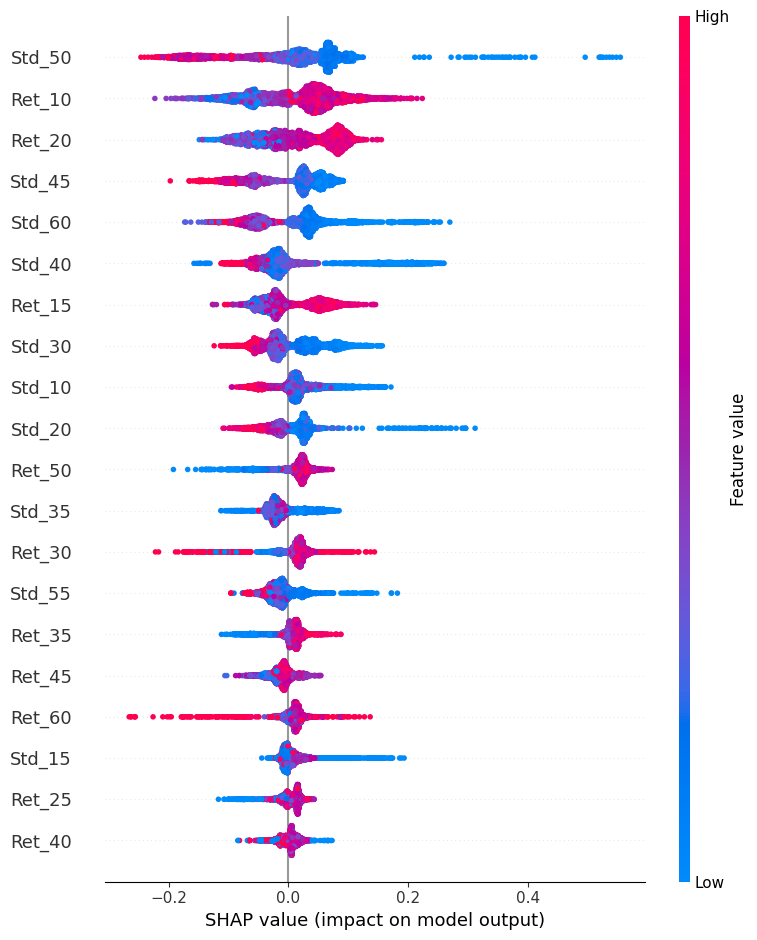

In [32]:
shap.summary_plot(shap_values, X_test)

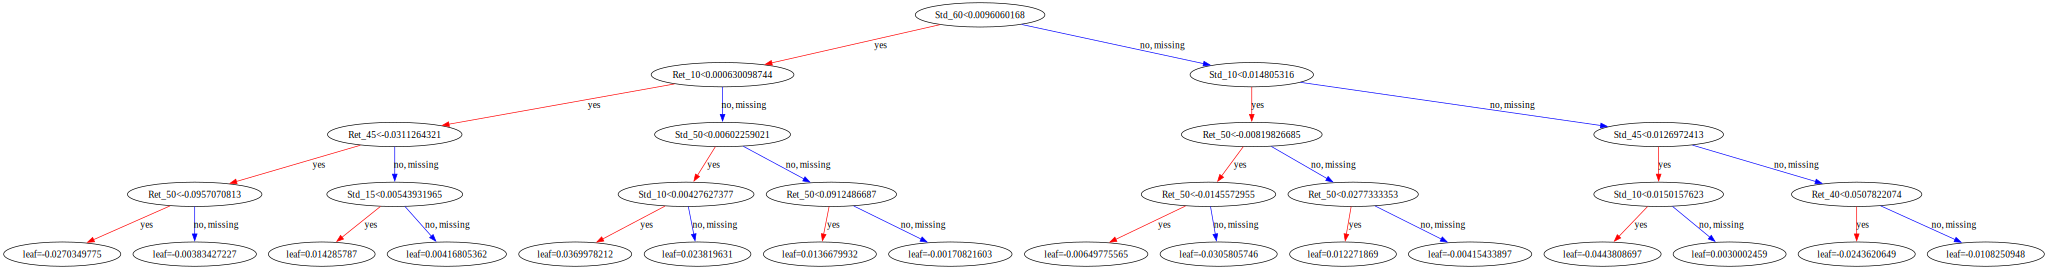

In [33]:
to_graphviz(cls, num_trees=10, rankdir='UT')

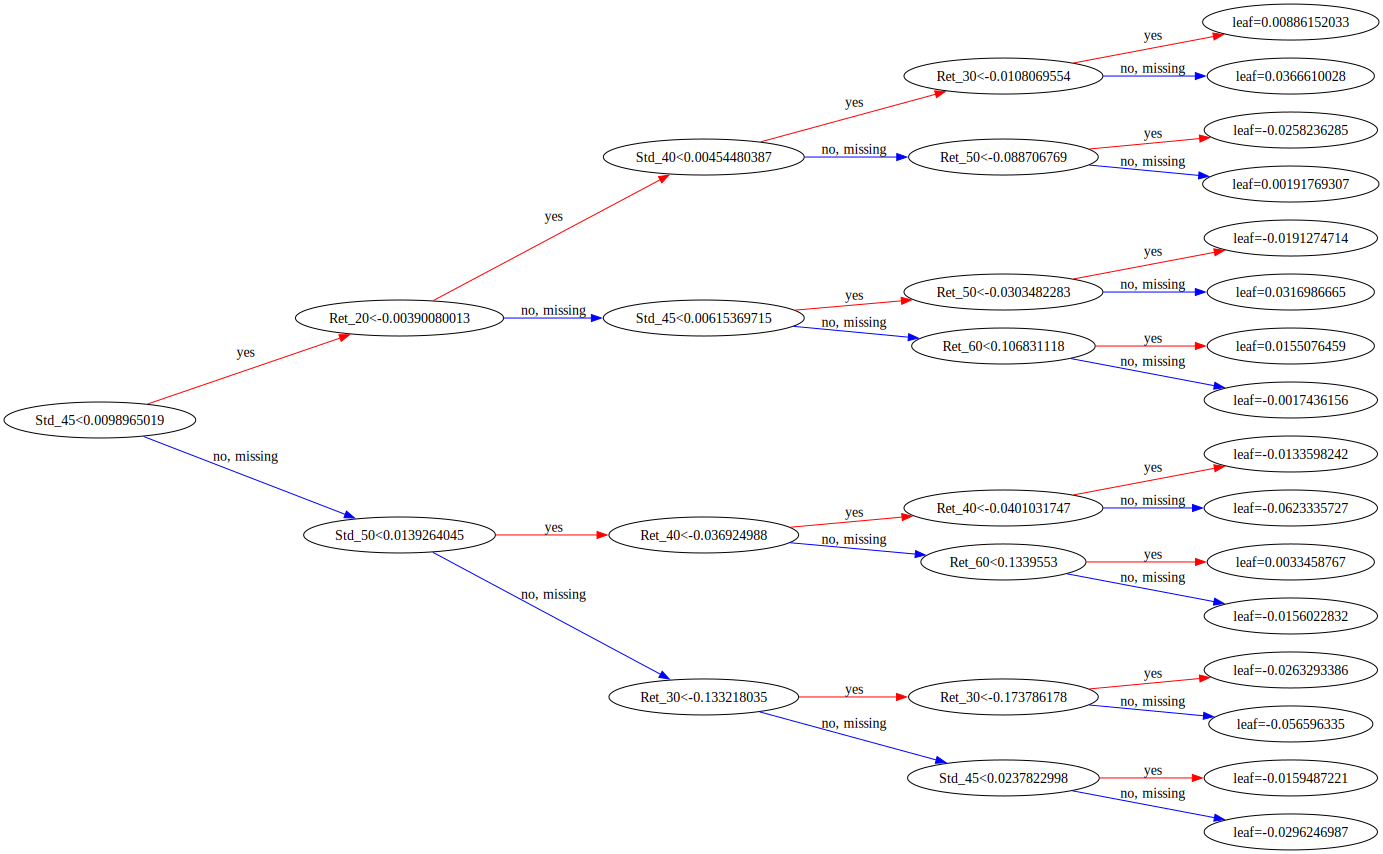

In [34]:
to_graphviz(cls, num_trees=5, rankdir='LR')

In [35]:
y_pred = cls.predict(X_test)

acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print('Training Accuracy:', acc_train)
print('Test Accuracy:', acc_test)

Training Accuracy: 0.7635815934351303
Test Accuracy: 0.7727461570419609


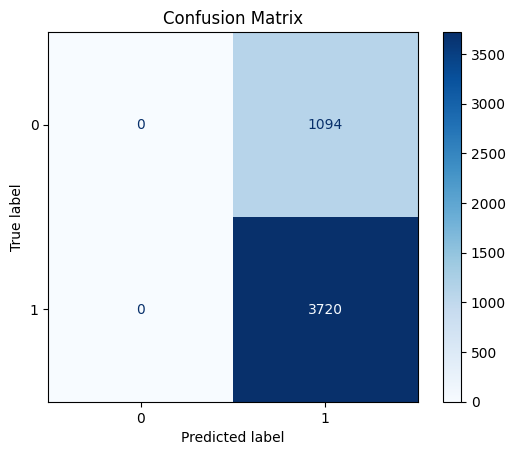

In [36]:
disp = ConfusionMatrixDisplay.from_estimator(cls, 
                                             X_test, 
                                             y_test,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues
                                            )
disp.ax_.set_title('Confusion Matrix')
plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1094
           1       0.77      1.00      0.87      3720

    accuracy                           0.77      4814
   macro avg       0.39      0.50      0.44      4814
weighted avg       0.60      0.77      0.67      4814



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

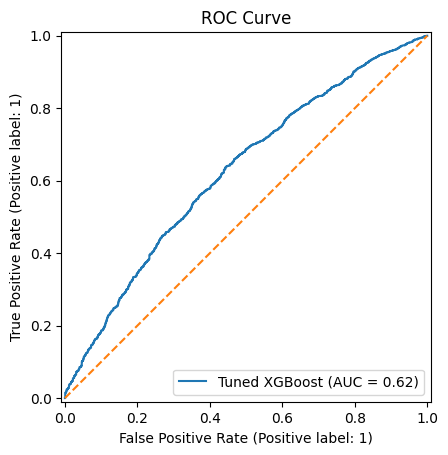

In [38]:
disp_roc = RocCurveDisplay.from_estimator(cls,
                                          X_test,
                                          y_test,
                                          name='Tuned XGBoost'
                                         )
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

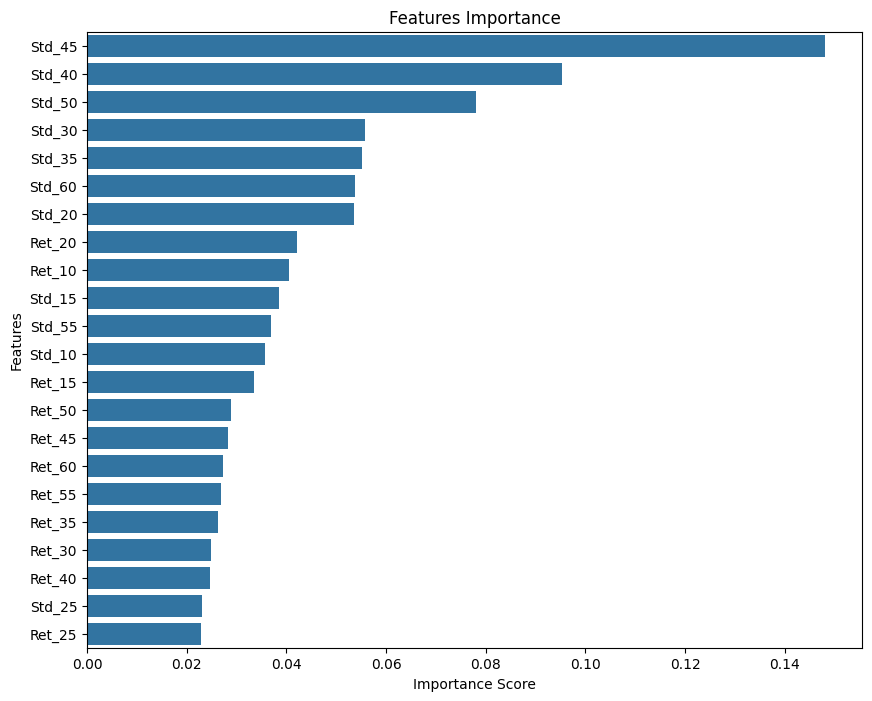

In [39]:
fig, ax = plt.subplots(figsize=(10,8))

feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,
                            'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

In [40]:
plot_importance?

Signature:
plot_importance(
    booster: Union[xgboost.sklearn.XGBModel, xgboost.core.Booster, dict],
    ax: Optional[Any] = None,
    height: float = 0.2,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
    title: str = 'Feature importance',
    xlabel: str = 'F score',
    ylabel: str = 'Features',
    fmap: Union[str, os.PathLike] = '',
    importance_type: str = 'weight',
    max_num_features: Optional[int] = None,
    grid: bool = True,
    show_values: bool = True,
    values_format: str = '{v}',
    **kwargs: Any,
) -> Any
Docstring:
Plot importance based on fitted trees.

Parameters
----------
booster :
    Booster or XGBModel instance, or dict taken by Booster.get_fscore()
ax : matplotlib Axes
    Target axes instance. If None, new figure and axes will be created.
grid :
    Turn the axes grids on or off.  Default is True (On).
importance_type :
    How the importance is calculated: either "weight", "gain", or "cover"

    * "weight" is the number of times

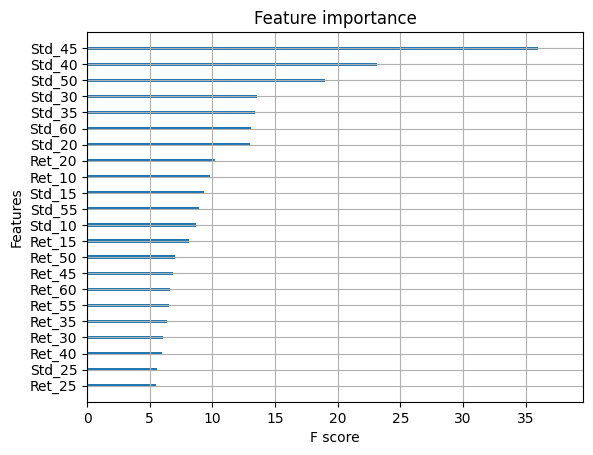

In [41]:
plot_importance(cls, importance_type='gain', show_values=False);

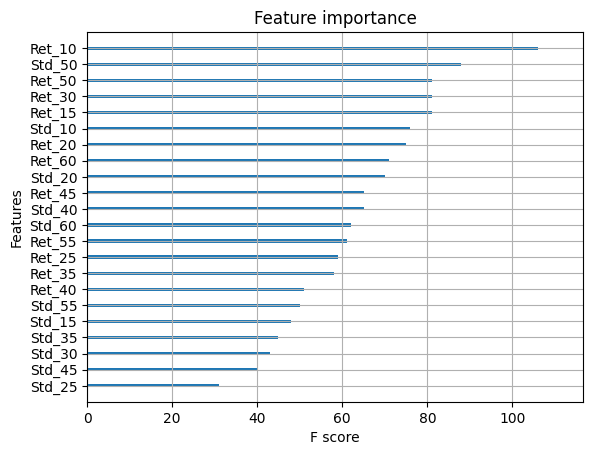

In [42]:
plot_importance(cls, importance_type='weight', show_values=False);

In [43]:
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

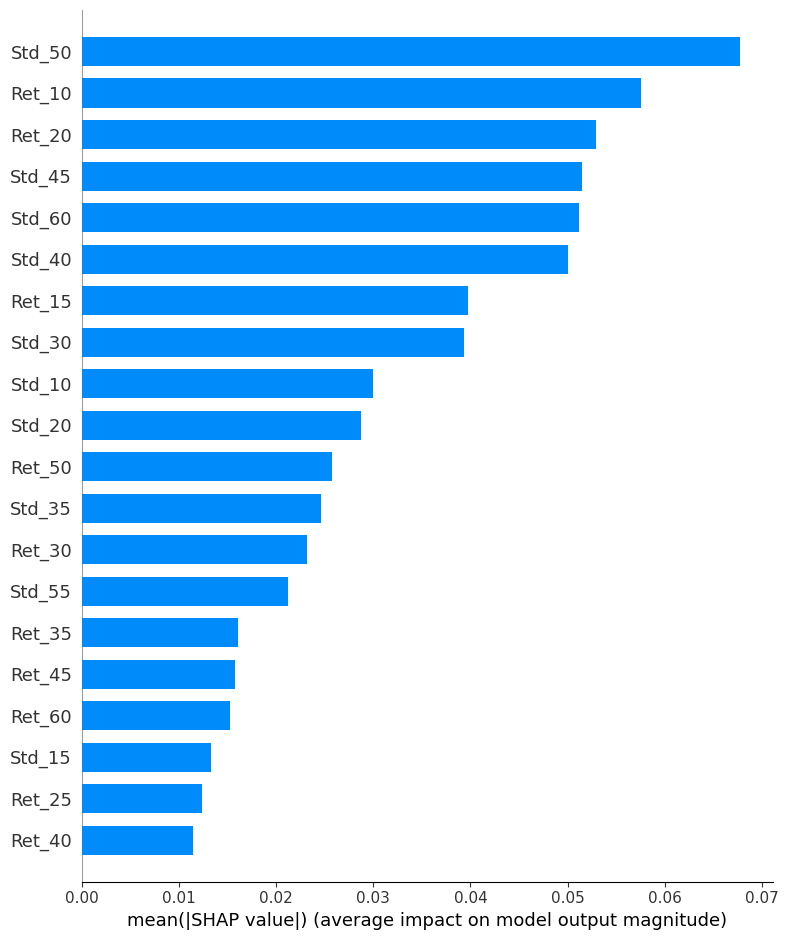

In [44]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

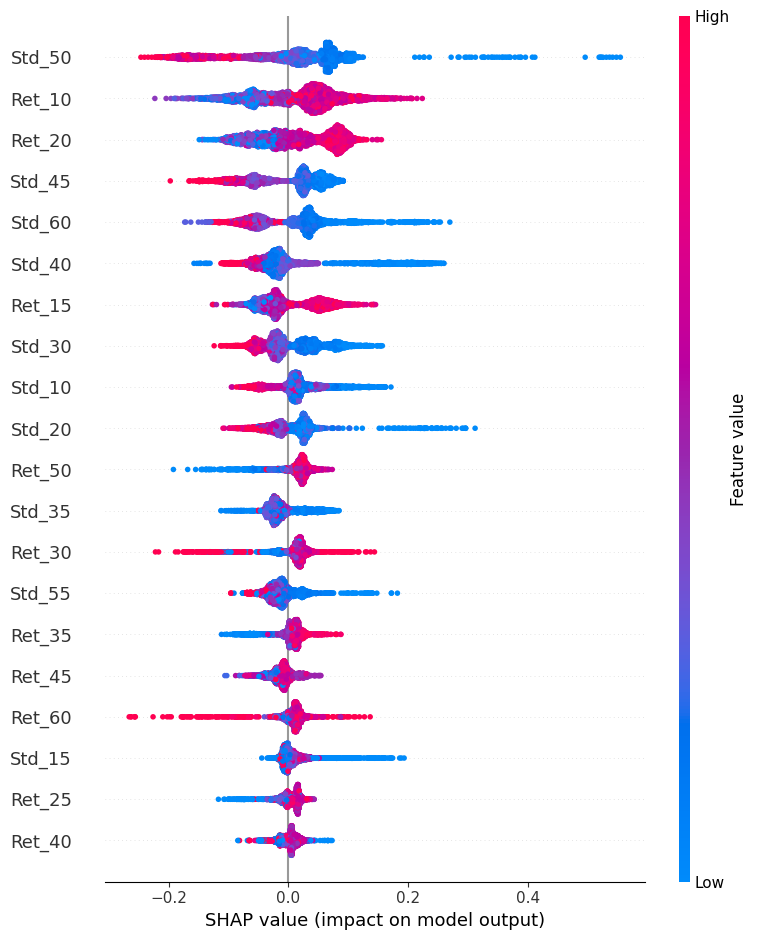

In [45]:
shap.summary_plot(shap_values, X_test)

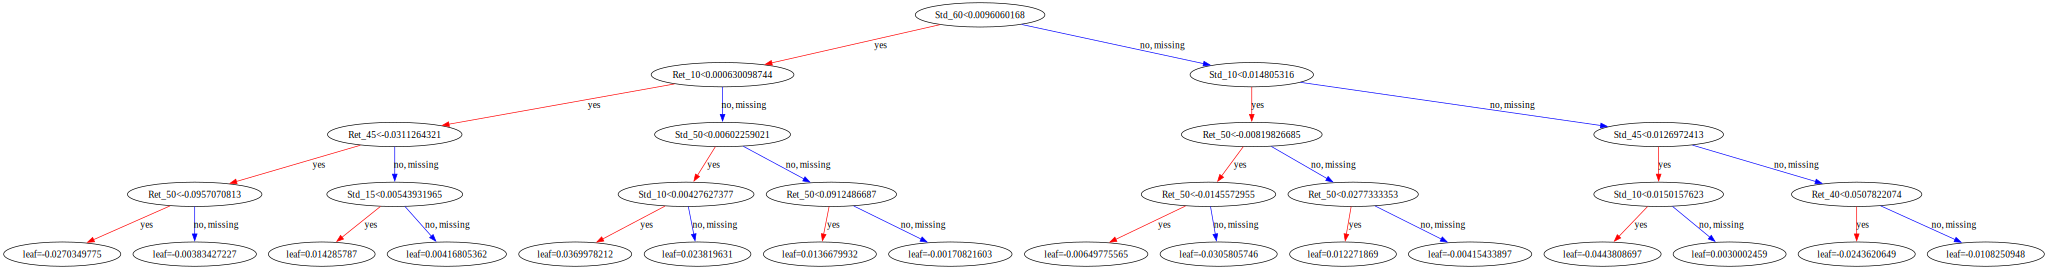

In [46]:
to_graphviz(cls, num_trees=10, rankdir='UT')

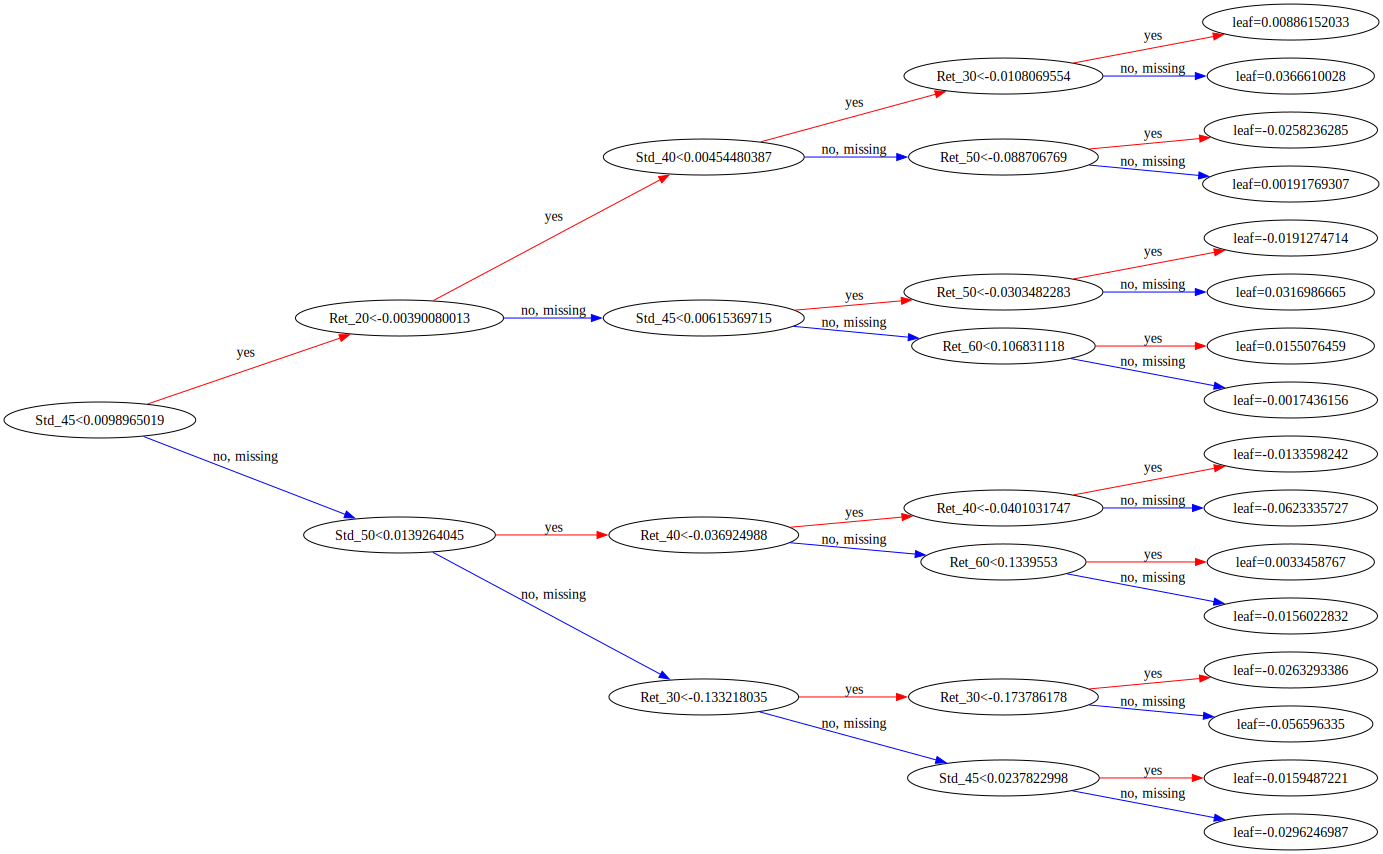

In [47]:
to_graphviz(cls, num_trees=5, rankdir='LR')